### IMPORTING NEEDED LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import *
from keras.layers import *
import keras.optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import vgg16, inception_v3, resnet50
from tensorflow.keras import backend

sns.set(style='white', context='notebook', palette='deep')

In [ ]:
def add_one_to_one_correlation_line(ax, min_factor=1, max_factor=1, **plot_kwargs):
    lim_min, lim_max = pd.DataFrame([ax.get_ylim(), ax.get_xlim()]).agg({0: 'min', 1: 'max'})
    lim_min *= min_factor
    lim_max *= max_factor
    plot_kwargs_internal = dict(color='grey', ls='--')
    plot_kwargs_internal.update(plot_kwargs)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], **plot_kwargs_internal)
    ax.set_ylim([lim_min, lim_max])
    ax.set_xlim([lim_min, lim_max])

### LOAD AND REVIEW DATA

In [ ]:
# Load the data
df = pd.read_csv("labels.csv")

In [ ]:
# Map each id to its appropriate file name
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

In [ ]:
df.describe()

,id,count
count,2000.000000,2000.000000
mean,1000.500000,31.157500
std,577.494589,6.945417
min,1.000000,13.000000
25%,500.750000,26.000000
50%,1000.500000,31.000000
75%,1500.250000,36.000000
max,2000.000000,53.000000


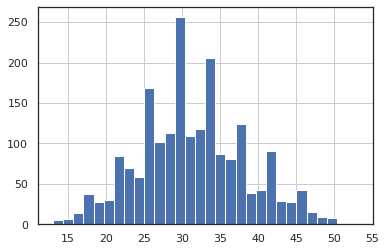

In [ ]:
df['count'].hist(bins=30);

In [ ]:
# Setup some constants
size = 224
batch_size = 64

### SETUP DATA GENERATOR

In [ ]:
# ImageDataGenerator - with defined augmentaions
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixels to [0,1]. This seems to work well with pretrained models.
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
#     rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.2, # Randomly zoom image 
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    validation_split=0.2,  # 20% of data randomly assigned to validation
    
    # This one is important:
    preprocessing_function=resnet50.preprocess_input,  # Whenever working with a pretrained model, it is said to be essential to use its provided preprocess
)

### LOAD IMAGE DATA

In [ ]:
flow_params = dict(
    dataframe=df,
    directory='frames',
    x_col="image_name",
    y_col="count",
    weight_col=None,
    target_size=(size, size),
    color_mode='rgb',
    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=0,
)

# The dataset is split to training and validation sets at this point
train_generator = datagen.flow_from_dataframe(
    subset='training',
    **flow_params    
)
valid_generator = datagen.flow_from_dataframe(
    subset='validation',
    **flow_params
)

Found 1175 validated image filenames.
Found 293 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 532 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


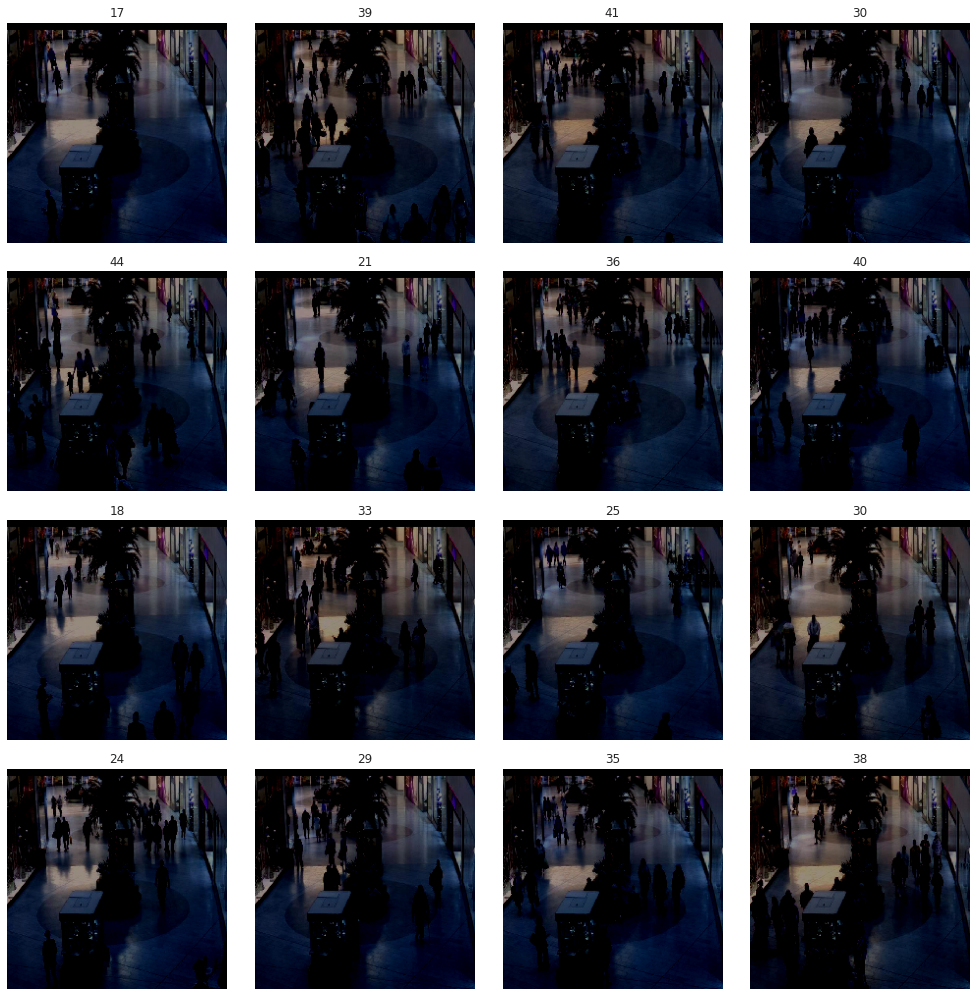

In [ ]:
batch = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()
for i in range(16):
    ax = axes[i]
    ax.imshow(batch[0][i])
    ax.axis('off')
    ax.set_title(batch[1][i])
plt.tight_layout()
plt.show()


### LOADING PRE-TRAINED RESNET50 MODEL

In [ ]:
base_model = resnet50.ResNet50(
    weights='imagenet',  # Load the pretrained weights, trained on the ImageNet dataset.
    include_top=False,  # We don't include the fully-connected layer at the top of the network - we need to modify the top.
    input_shape=(size, size, 3),  # 224x224 was the original size ResNet was trained on, so I decided to use this.
    pooling='avg',  # A global average pooling layer will be added after the last convolutional block.
)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# Here we change the top (the last parts) of the network.
x = base_model.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
k = -7
for layer in model.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense
dense_1


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### SET OPTIMIZER

In [ ]:
 #Define the optimizer - this function will iteratively improve parameters in order to minimise the loss. 
# The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.
optimizer = Adam(
    # The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.
    learning_rate=0.001
    # Additional parameters to play with:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)



In [ ]:

from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001, decay=1e-6)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### COMPILE MODEL

In [ ]:
# Compile the model
model.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [ ]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1, 
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

### FITTING THE MODEL

In [ ]:
# Fit the model
history = model.fit_generator(
    generator=train_generator,
    epochs=50,  # 50 epochs seems to have reached the minimal loss for this setup
    validation_data=valid_generator,
    verbose=2, 
    callbacks=[learning_rate_reduction],
)
print('\nDone.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
19/19 - 252s - loss: 156.4077 - mean_absolute_error: 9.0765 - mean_squared_error: 156.4077 - val_loss: 2236.9812 - val_mean_absolute_error: 46.9047 - val_mean_squared_error: 2236.9812 - lr: 0.0010 - 252s/epoch - 13s/step
Epoch 2/50
19/19 - 234s - loss: 37.2935 - mean_absolute_error: 4.9062 - mean_squared_error: 37.2935 - val_loss: 1722.4803 - val_mean_absolute_error: 41.1217 - val_mean_squared_error: 1722.4803 - lr: 0.0010 - 234s/epoch - 12s/step
Epoch 3/50
19/19 - 234s - loss: 31.7383 - mean_absolute_error: 4.5115 - mean_squared_error: 31.7383 - val_loss: 1005.3693 - val_mean_absolute_error: 31.2402 - val_mean_squared_error: 1005.3693 - lr: 0.0010 - 234s/epoch - 12s/step
Epoch 4/50
19/19 - 234s - loss: 29.1328 - mean_absolute_error: 4.3186 - mean_squared_error: 29.1328 - val_loss: 537.3419 - val_mean_absolute_error: 22.5587 - val_mean_squared_error: 537.3419 - lr: 0.0010 - 234s/epoch - 12s/step
Epoch 5/50
19/19 - 233s - loss: 27.6601 - mean_absolute_error: 4.2088 - mean_squ

### EVALUATION OF THE MODEL

#### TRAINING AND VALIDATION CURVES

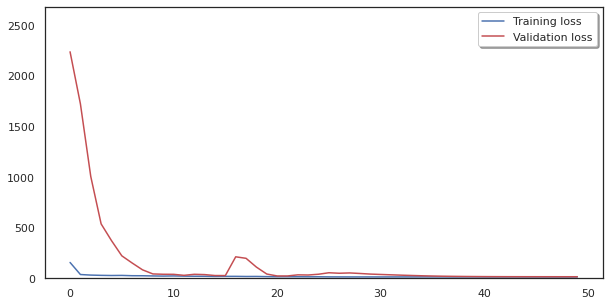

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)

In [ ]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels = np.concatenate(all_labels)
cat_pred = np.concatenate(all_pred)

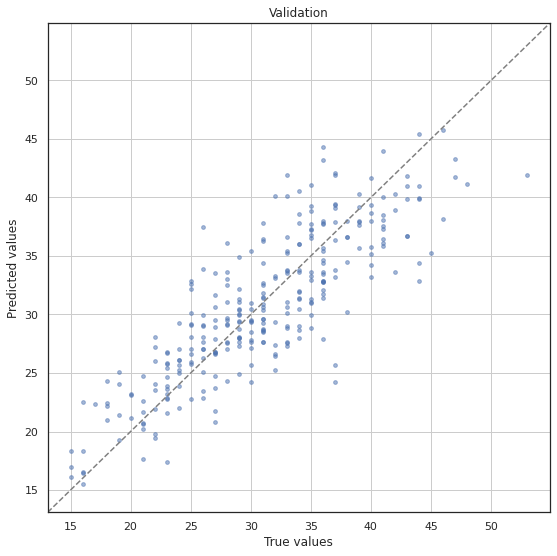

In [ ]:
df_predictions = pd.DataFrame({'True values': cat_labels, 'Predicted values': cat_pred})
ax = df_predictions.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

In [ ]:
mse = mean_squared_error(*df_predictions.T.values)
pearson_r = sc.stats.pearsonr(*df_predictions.T.values)[0]

print(f'MSE: {mse:.1f}\nPearson r: {pearson_r:.1f}')

MSE: 15.4
Pearson r: 0.8
